# Import 

In [1]:
# STANDARD PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
import re	
from datetime import datetime as dt
import time
import json
import random
from tqdm import tqdm #https://pypi.org/project/tqdm/#ipython-jupyter-integ½ration
from functools import reduce
import pickle
import itertools

# SCRAPE PACKAGES
import requests
from bs4 import BeautifulSoup
# from pytrends.request import TrendReq #pip install pytrends

# MODEL PACKAGES
    #SKLEARN
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from statsmodels.tsa.x13 import x13_arima_analysis as x13
from scipy.stats import gaussian_kde

# CUSTOM FUNCTIONS

import os
import sys
currentdir = os.path.dirname(os.path.realpath('analysis_DK'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)


# CUSTOM FUNCTIONS
from func import (chunks, reindex, global_id, term_list, time_corr_plot, rmse, time_variable_plot, find_highest_corr, test_train_split,
                  bootstrap_all_windows, bootstrap_n_samples, bootstrap_sample, final_model, final_model_boot, ar_1, grid_bestpar,
                  tuning_window, tuning_window_bestpar, model_tuning, seasadj, GT_dict)

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Initial descriptives

## Google trends

Imports:

In [2]:
df_descriptive = pd.read_csv('data/descriptive/df_descriptive.csv', parse_dates=['date'])

GT_dict = GT_dict()

In [3]:
df_descriptive = df_descriptive.drop(['GT_DK_0', 'GT_DK_1', 'GT_DK_2', 'GT_DK_3', 'GT_DK_4', 'GT_DK_5', 'GT_DK_6', 'GT_DK_7', 'GT_DK_8', 
                     'GT_DK_9', 'GT_DK_10', 'GT_DK_11', 'GT_DK_12', 'GT_DK_13', 'GT_DK_14', 'GT_DK_15', 'GT_DK_16', 
                     'GT_DK_17', 'GT_DK_18', 'GT_DK_19', 'GT_DK_20', 'GT_DK_21', 'GT_NO_0', 'GT_NO_1', 'GT_NO_2', 
                     'GT_NO_6', 'GT_NO_7', 'GT_NO_8', 'GT_NO_10', 'GT_NO_11'], axis = 1)

### Sample test correlation plots

https://matplotlib.org/gallery/api/two_scales.html

#### SE

In [4]:
filter_SE = [col for col in df_descriptive if col.startswith('GT_SE')]

In [5]:
df_descriptive[df_descriptive['country'] == 'SE']['ID'].unique()

array(['Blekinge', 'Dalarna', 'Gotland', 'Gävleborg', 'Halland',
       'Jämtland', 'Jönköping', 'Kalmar', 'Kronoberg', 'Norrbotten',
       'Skåne', 'Stockholm', 'Södermanland', 'Uppsala', 'Värmland',
       'Västerbotten', 'Västernorrland', 'Västmanland',
       'Västra Götalands', 'Örebro', 'Östergötland'], dtype=object)

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


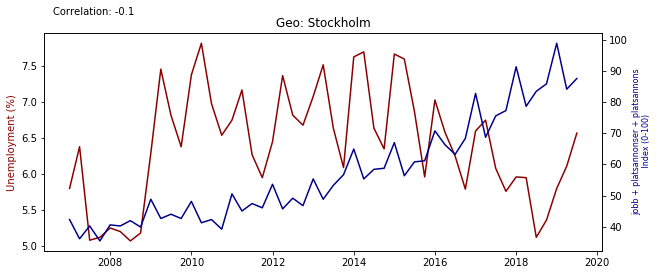

In [6]:
time_corr_plot(df = df_descriptive, var_list = filter_SE[0:1], target = 'target_actual',  geo = 'Stockholm', ylabel1 = 'Unemployment (%)', ylabel2 = '\n Index (0-100)')

### Correlation tables for each region

##### Correlation heatmap

https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

https://www.kaggle.com/drazen/heatmap-with-sized-markers

https://github.com/drazenz/heatmap

In [7]:
df_descriptive = pd.read_csv('data/descriptive/df_descriptive.csv', parse_dates=['date'])

In [8]:
print(list(df_descriptive))

['date', 'target_actual', 'ID', 'jobs', 'sector_information_technology', 'sector_engineering_technology', 'sector_management_staff', 'sector_trade_service', 'sector_industry_craft', 'sector_sales_communication', 'sector_teaching', 'sector_office_finance', 'sector_social_health', 'sector_other', 'population', 'high_edu_share', 'labour_force_share', 'urban_share', 'country', 'GT_DK_0', 'GT_DK_1', 'GT_DK_2', 'GT_DK_3', 'GT_DK_4', 'GT_DK_5', 'GT_DK_6', 'GT_DK_7', 'GT_DK_8', 'GT_DK_9', 'GT_DK_10', 'GT_DK_11', 'GT_DK_12', 'GT_DK_13', 'GT_DK_14', 'GT_DK_15', 'GT_DK_16', 'GT_DK_17', 'GT_DK_18', 'GT_DK_19', 'GT_DK_20', 'GT_DK_21', 'GT_NO_0', 'GT_NO_1', 'GT_NO_2', 'GT_NO_6', 'GT_NO_7', 'GT_NO_8', 'GT_NO_10', 'GT_NO_11', 'GT_SE_0', 'GT_SE_1', 'GT_SE_2', 'GT_SE_5', 'GT_SE_6', 'GT_SE_7', 'GT_SE_8', 'GT_SE_9', 'GT_SE_10', 'GT_SE_11']


In [9]:
df_descriptive = df_descriptive[df_descriptive.date >= '01-01-2008']

In [10]:
df_descriptive = df_descriptive[~(df_descriptive.ID == 'Jämtland')]

In [11]:
#Empty container
df = {}

In [12]:
#Overall correlations
df_corr = df_descriptive.corr()[['target_actual']]

#corr col for names of cols - append with _season if needed
corr_col = ['target_actual']

In [13]:
#Within geo correlations
for geo in df_descriptive[df_descriptive['country']=='SE']['ID'].unique():
    df[geo] = df_descriptive[df_descriptive['ID']==geo].corr()[['target_actual']].rename(index = str,
                                                                                            columns = {'target_actual' : 'target_actual_'+str(geo)})
    df_corr[['target_actual_'+str(geo)]] = df[geo][['target_actual_'+str(geo)]]
    
    #Appending corr_col list for col names
    corr_col.append('target_actual_'+str(geo))

In [14]:
#Dropping unneeded corr between targets
df_corr.drop(['target_actual'], axis = 0, inplace=True)

In [15]:
df_corr.columns

Index(['target_actual', 'target_actual_Blekinge', 'target_actual_Dalarna',
       'target_actual_Gotland', 'target_actual_Gävleborg',
       'target_actual_Halland', 'target_actual_Jönköping',
       'target_actual_Kalmar', 'target_actual_Kronoberg',
       'target_actual_Norrbotten', 'target_actual_Skåne',
       'target_actual_Stockholm', 'target_actual_Södermanland',
       'target_actual_Uppsala', 'target_actual_Värmland',
       'target_actual_Västerbotten', 'target_actual_Västernorrland',
       'target_actual_Västmanland', 'target_actual_Västra Götalands',
       'target_actual_Örebro', 'target_actual_Östergötland'],
      dtype='object')

In [16]:
GT_select = df_corr[['target_actual_Blekinge', 'target_actual_Dalarna',
       'target_actual_Gotland', 'target_actual_Gävleborg',
       'target_actual_Halland',
       'target_actual_Jönköping', 'target_actual_Kalmar',
       'target_actual_Kronoberg', 'target_actual_Norrbotten',
       'target_actual_Skåne', 'target_actual_Stockholm',
       'target_actual_Södermanland', 'target_actual_Uppsala',
       'target_actual_Värmland', 'target_actual_Västerbotten',
       'target_actual_Västernorrland', 'target_actual_Västmanland',
       'target_actual_Västra Götalands', 'target_actual_Örebro',
       'target_actual_Östergötland']]

GOOGLE

In [17]:
gt_filter = ['GT_SE_0', 'GT_SE_1', 'GT_SE_2', 'GT_SE_5', 'GT_SE_6', 'GT_SE_7', 'GT_SE_8', 'GT_SE_9', 'GT_SE_10', 'GT_SE_11']

In [18]:
keep_list = []
drop_list = []

for GT in gt_filter:
    if (abs(GT_select.loc[GT].mean())>=0.20):
        keep_list.append(GT)
    else:
        drop_list.append(GT)

In [19]:
print(keep_list)

['GT_SE_0', 'GT_SE_1', 'GT_SE_2', 'GT_SE_7', 'GT_SE_9']


In [20]:
print(drop_list)

['GT_SE_5', 'GT_SE_6', 'GT_SE_8', 'GT_SE_10', 'GT_SE_11']


In [21]:
for GT in gt_filter:
        print(GT + ': '+ GT_dict[GT] + ' : ' + str(round(GT_select.loc[GT].mean(), 2)))

GT_SE_0: jobb + platsannonser + platsannons : -0.29
GT_SE_1: arbetsförmedlingen : 0.43
GT_SE_2: "lediga platser" + "lediga jobb" + vakans : -0.34
GT_SE_5: försörjningsstöd + socialbidrag + "socialbidrag krav" + "ekonomiskt bistånd" : 0.18
GT_SE_6: jobbsafari : 0.08
GT_SE_7: platsbanken + "platsbanken arbetsförmedlingen" : 0.54
GT_SE_8: a-kassa + akassa + "a kassa" : 0.12
GT_SE_9: arbetslöshetsersättningen + ersättning + ersättningsperiode : -0.23
GT_SE_10: unionen + htf + sif + tjänstemannaförbundet + "Svenska industritjänstemannaförbundet" : 0.02
GT_SE_11: lo + landsorganisationen + "landsorganisationen sverige" : -0.0


JOBINDEX

In [22]:
df_descriptive.columns

Index(['date', 'target_actual', 'ID', 'jobs', 'sector_information_technology',
       'sector_engineering_technology', 'sector_management_staff',
       'sector_trade_service', 'sector_industry_craft',
       'sector_sales_communication', 'sector_teaching',
       'sector_office_finance', 'sector_social_health', 'sector_other',
       'population', 'high_edu_share', 'labour_force_share', 'urban_share',
       'country', 'GT_DK_0', 'GT_DK_1', 'GT_DK_2', 'GT_DK_3', 'GT_DK_4',
       'GT_DK_5', 'GT_DK_6', 'GT_DK_7', 'GT_DK_8', 'GT_DK_9', 'GT_DK_10',
       'GT_DK_11', 'GT_DK_12', 'GT_DK_13', 'GT_DK_14', 'GT_DK_15', 'GT_DK_16',
       'GT_DK_17', 'GT_DK_18', 'GT_DK_19', 'GT_DK_20', 'GT_DK_21', 'GT_NO_0',
       'GT_NO_1', 'GT_NO_2', 'GT_NO_6', 'GT_NO_7', 'GT_NO_8', 'GT_NO_10',
       'GT_NO_11', 'GT_SE_0', 'GT_SE_1', 'GT_SE_2', 'GT_SE_5', 'GT_SE_6',
       'GT_SE_7', 'GT_SE_8', 'GT_SE_9', 'GT_SE_10', 'GT_SE_11'],
      dtype='object')

In [23]:
gt_filter = ['sector_information_technology',
       'sector_engineering_technology', 'sector_management_staff',
       'sector_trade_service', 'sector_industry_craft',
       'sector_sales_communication', 'sector_teaching',
       'sector_office_finance', 'sector_social_health', 'sector_other']

In [24]:
keep_list = []
drop_list = []

for GT in gt_filter:
    if (abs(GT_select.loc[GT].mean())>=0.19):
        keep_list.append(GT)
    else:
        drop_list.append(GT)

In [25]:
for GT in gt_filter:
    print(GT + ': '+ GT + ' : ' + str(round(GT_select.loc[GT].mean(), 2)))

sector_information_technology: sector_information_technology : -0.31
sector_engineering_technology: sector_engineering_technology : -0.21
sector_management_staff: sector_management_staff : -0.06
sector_trade_service: sector_trade_service : -0.08
sector_industry_craft: sector_industry_craft : -0.24
sector_sales_communication: sector_sales_communication : -0.1
sector_teaching: sector_teaching : -0.01
sector_office_finance: sector_office_finance : -0.2
sector_social_health: sector_social_health : -0.13
sector_other: sector_other : -0.05


In [26]:
print(keep_list)

['sector_information_technology', 'sector_engineering_technology', 'sector_industry_craft', 'sector_office_finance']


In [27]:
print(drop_list)

['sector_management_staff', 'sector_trade_service', 'sector_sales_communication', 'sector_teaching', 'sector_social_health', 'sector_other']


## Desriptive table 

In [28]:
filter_region = ['target_actual', 'population', 'high_edu_share', 'labour_force_share', 'urban_share']

In [30]:
df_descriptive[filter_region].mean().round(2).reset_index()

,index,0
0,target_actual,7.54
1,population,474428.28
2,high_edu_share,22.10
3,labour_force_share,72.46
4,urban_share,80.79


In [31]:
df_descriptive[filter_region].std().round(2).reset_index()

,index,0
0,target_actual,1.78
1,population,527473.98
2,high_edu_share,3.64
3,labour_force_share,2.38
4,urban_share,6.93


In [29]:
df_descriptive.groupby('ID')[filter_region].mean().round(2).reset_index()

,ID,target_actual,population,high_edu_share,labour_force_share,urban_share
0,Blekinge,8.72,154379.83,21.61,71.04,80.28
1,Dalarna,7.51,279030.23,18.47,71.70,80.41
2,Gotland,6.34,57490.96,19.98,72.69,59.10
3,Gävleborg,8.83,279076.15,18.29,70.60,78.59
4,Halland,5.84,306506.53,22.12,74.59,80.40
5,Jönköping,6.00,342585.64,19.42,74.71,82.82
6,Kalmar,7.05,236154.13,19.32,70.85,77.89
7,Kronoberg,7.20,187685.60,21.32,74.32,77.77
8,Norrbotten,7.28,249730.21,20.92,70.24,82.19
9,Skåne,8.94,1269582.30,25.28,73.39,88.75


In [155]:
print(df_descriptive.groupby('ID')[filter_region].mean().round(1).reset_index().to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
               ID &  target\_actual &  population &  high\_edu\_share &  labour\_force\_share &  urban\_share \\
\midrule
         Blekinge &            8.6 &    154134.4 &            21.4 &                71.1 &         80.2 \\
          Dalarna &            7.4 &    278770.8 &            18.3 &                71.7 &         80.3 \\
          Gotland &            6.4 &     57479.5 &            19.8 &                72.8 &         59.0 \\
        Gävleborg &            8.6 &    278814.4 &            18.1 &                70.6 &         78.5 \\
          Halland &            5.8 &    305063.8 &            21.9 &                74.7 &         80.3 \\
        Jönköping &            5.9 &    341692.6 &            19.2 &                74.8 &         82.8 \\
           Kalmar &            6.9 &    235970.9 &            19.1 &                70.8 &         77.8 \\
        Kronoberg &            7.0 &    187030.8 &            21.1 &                74.5 &      

## Distribution of 1st differnce in target

In [2]:
df_descriptive = pd.read_csv('data/descriptive/df_analysis.csv', parse_dates=['date'])

In [3]:
df_descriptive['target_diff'] = df_descriptive.groupby('ID')['target_actual'].diff()

In [4]:
    # FOR PLOTS
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size' : 15})
rc('text', usetex=True)
rc('legend',fontsize=14)


#Colors 
color_rgb = [(0.26, 0.33, 0.41), (0.00, 0.47, 0.53),(0.65, 0.65, 0.65),  (0.13, 0.50, 0.36), (0.54, 0.23, 0.23), (0.54, 0.23, 0.23)]

linewidth = 1.5

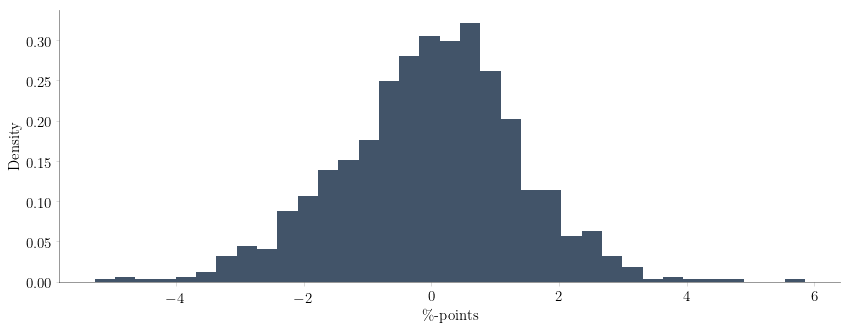

In [9]:
fig, ax = plt.subplots(figsize = (14,5))

density = gaussian_kde(df_descriptive['target_diff'].dropna())
xs = np.linspace(-6,6,200)

#plt.plot(xs,density(xs), linewidth = 2.5, color = color_rgb[0])
plt.hist(df_descriptive['target_diff'].dropna(), density = True, color = color_rgb[0], bins = 35)


ax.set_ylabel('Density')
ax.set_xlabel('\%-points')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)
ax.tick_params(axis='x', color = 'lightgrey')
ax.tick_params(axis='y', color = 'lightgrey')

#Exporting
plt.savefig("report/8_robustness_SE/8_1stdiff_dist.pdf", bbox_inches='tight', encoding='utf-8-sig')
plt.show()

In [142]:
df_descriptive.date.min()

Timestamp('2007-01-01 00:00:00')

In [140]:
df_descriptive['target_diff'].dropna().describe(include = 'all')

count    1000.000000
mean       -0.015990
std         1.407324
min        -5.270000
25%        -0.860000
50%         0.070000
75%         0.852500
max         5.850000
Name: target_diff, dtype: float64

In [23]:
df_descriptive['target_diff'].dropna().median()

0.07000000000000028